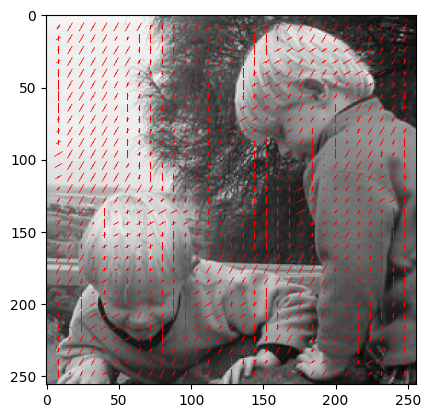

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def get_differential_filter():
    # TODO: implement this function
    
    # use sobel fiter for the gradient calculation
    filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])    
    return filter_x, filter_y


def filter_image(im, filter):
    # TODO: implement this function
    
    # in this function, apply the filter for the given image
    # in this implementation, I restricted that image is always grayscale.
    
    image_height,image_width = im.shape# drop the channel element due to the assumption of this implementation
    filter_height,filter_width = filter.shape
    
    # I tried to use zero padding method. I'm not consider the striding since I assume that our image is small enough.
    padding_width = filter_width//2
    padding_height = filter_height//2
    
    padded_im = np.pad(im,(padding_height,padding_width),mode = "constant")
    
    im_filtered = np.zeros((image_height,image_width))
    
    # do convolution
    for i in range(0,image_height):
        for j in range(0,image_width):
            for k in range(0,filter_height,1):
                for l in range(0,filter_width,1):
                    im_filtered[i,j] +=padded_im[i+k,j+l]*filter[k,l]        
    
    return im_filtered

# def filter_image(im, filter):
#     return cv2.filter2D(im, -1, filter)



def get_gradient(im_dx, im_dy):
    # TODO: implement this function
    grad_mag = np.sqrt(im_dx**2 + im_dy**2)
    grad_angle = np.arctan2(im_dy, im_dx)
    grad_angle[grad_angle < 0] += np.pi
    return grad_mag, grad_angle


def build_histogram(grad_mag, grad_angle, cell_size):
    # TODO: implement this function
    h,w = grad_mag.shape
    h_cell = int(h/cell_size)
    w_cell = int(w/cell_size)
    
    ori_histo = np.zeros(h_cell* w_cell*6, dtype=np.float32).reshape(h_cell,w_cell,6)
    
    
    for i in range(h_cell):
        for j in range(w_cell):
            cell_ang = grad_angle[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_mag = grad_mag[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            tmp_hist, _ = np.histogram(cell_ang, bins=6, range=(0, np.pi*2), weights=cell_mag)

            # Accumulate the histogram values
            ori_histo[i, j, :] = tmp_hist
    return ori_histo


def get_block_descriptor(ori_histo, block_size):
    # TODO: implement this function
    
    h,w,_ = ori_histo.shape
        
    ori_histo_normalized = np.zeros((h-1,w-1,6*block_size*block_size))
    
    for i in range(h - block_size+1):
        for j in range(w - block_size+1):
            
            tmp_hist = ori_histo[i:i+block_size,j:j+block_size,:].flatten()
            tmp_hist /=np.sqrt(np.sum(tmp_hist**2) + 1e-6)
            ori_histo_normalized[i,j,:] = tmp_hist
    return ori_histo_normalized


# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized

    
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    # plt.show()
    plt.savefig('hog.png')
    plt.savefig('./figrues/hog4.png')


def extract_hog(im, visualize=False, cell_size=8, block_size=2):
    # TODO: implement this function
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(im, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)# normalize
    filter_x, filter_y = get_differential_filter()
    img_filtered_x = filter_image(img,filter_x)
    img_filtered_y = filter_image(img,filter_y)
    grad_mag, grad_ang = get_gradient(img_filtered_x,img_filtered_y)
    im_hist = build_histogram(grad_mag,grad_ang,cell_size)
    # print(im_hist.shape)
    im_hist_normalized = get_block_descriptor(im_hist,block_size)
    hog = im_hist_normalized.flatten()
    if visualize:
        visualize_hog(img,hog,cell_size=cell_size,block_size=block_size)
    return hog


def face_recognition(I_target, I_template):
    # TODO: implement this function
    hog_template = extract_hog(I_template)
    hog_template = hog_template - np.mean(hog_template)

    h_tem, w_tem = I_template.shape
    h,w = I_target.shape
    

    tmp_bounding_boxes = np.zeros((h*w,3))
    cnt = 0
    for i in range(h - h_tem):
        for j in range(w - w_tem):
            # print(str(i)+", " + str(j) )
            I_temp = I_target[i:i+h_tem,j:j+w_tem]

            hog_image = extract_hog(I_temp)
            hog_image = hog_image - np.mean(hog_image)
            s = np.dot(hog_image,hog_template)/(np.linalg.norm(hog_image,2)*np.linalg.norm(hog_template,2))
            
            if s>0.65:
                tmp_bounding_boxes[cnt,:] = [j,i,s]
                cnt+=1
                
    bounding_boxes = non_maximum_suppression(tmp_bounding_boxes[:cnt],(h_tem,w_tem))
                
    return bounding_boxes

def non_maximum_suppression(bb_set,box_size):
    sorted_bb_set = sorted(bb_set,key = lambda x : x[2], reverse = True)
    bounding_boxes = np.zeros((3,))
    bounding_boxes = np.r_[[bounding_boxes],[sorted_bb_set[0]]]
    for i in range(len(sorted_bb_set)):
        # print(str(i) + ": " + str(len(bounding_boxes)))
        target_bb = list(sorted_bb_set[i])
        isDiscared = False
        for j in range(len(sorted_bb_set)):
            if np.abs(getIOU(target_bb,bb_set[j],box_size[0],box_size[1]))>0.5:
                if target_bb[2] < bb_set[j,2] : 
                    isDiscared = True
        if not isDiscared:
            bounding_boxes = np.r_[bounding_boxes,[target_bb]]
    bounding_boxes = bounding_boxes[1:]
    return bounding_boxes

def getIOU(cor_1,cor_2,h,w):
    # this is my own function which calculates the IOU of BB
    box1_area = h*w
    box2_area = h*w

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(cor_1[0], cor_2[0])
    y1 = max(cor_1[1], cor_2[1])
    x2 = min(cor_1[0] + w, cor_2[0] + w)
    y2 = min(cor_1[1]+ h, cor_2[1] + h)

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou


def visualize_face_detection(I_target, bounding_boxes, box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    for ii in range(bounding_boxes.shape[0]):

        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size 
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1=0
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1
        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.imsave('result_face_detection.png', fimg, vmin=0, vmax=1)
    plt.show()


if __name__=='__main__':
    # correct the path before the submission
    # im = cv2.imread('./cameraman.tif', 0)

    # im = cv2.imread('./einstein.png',0)
    # im = cv2.imread("./cat.tif",0)
    im = cv2.imread("./twins.tif",0)
    hog = extract_hog(im, visualize=True)
    
    
    
    # I_target= cv2.imread('target.png', 0) # MxN image

    # I_template = cv2.imread('template.png', 0) # mxn  face template

    # bounding_boxes = face_recognition(I_target, I_template)

    # I_target_c= cv2.imread('target.png') # MxN image (just for visualization)
    
    # visualize_face_detection(I_target_c, bounding_boxes, I_template.shape[0]) # visualization code



